 # Steven Lora - MSIT675 Project 3 -  LSTM model for sentiment analysis
 In this project you will:
 1. Train and evaluate a bidirectional LSTM model for sentiment analysis using the [IMDB dataset](https://keras.io/api/datasets/imdb/).
 2. Finetune a [pretrained GPT-2 model](https://keras.io/keras_hub/api/models/gpt2/) using the IMDB dataset to generate positive reviews.
 3. Predict the probability reviews generated by your finetuned GPT-2 model are positive.

## Import

In [ ]:
import numpy as np
import keras
from keras import layers
from sklearn.metrics import roc_auc_score, classification_report
import matplotlib.pyplot as plt

## Specify parameters

In [ ]:
VOCAB_SIZE = 40000  # Consider only the most frequent VOCAB_SIZE words
MAX_LENGTH = 400 # Up to MAX_LENGTH words in a comment is considered
EMBED_DIM = 64 # Embedding dimension for words
LSTM_DIM = 32 # LSTM dimension

The required libraries are imported to support model training, text preprocessing, generation, and evaluation.
The parameters defined above (e.g., vocab size, sequence length, embedding dimensions) control the tokenizer and neural network architecture for classifying IMDB sentiment.

## Get Data

In [ ]:
def get_data(vocab_size):
  (x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=vocab_size)
  WI = keras.datasets.imdb.get_word_index() # maps words to indices
  REV_WI = dict([(value, key) for (key, value) in WI.items()]) # maps indices to words
  return (x_train, y_train), (x_test, y_test), WI, REV_WI

def to_wds(idx_list, REV_WI):
  """Returns text corresponding to idx_list using REV_WI"""
  return ' '.join([REV_WI.get(i-3, '?') for i in idx_list[1:]])

def to_seq(text, WI):
  """Returns sequence corresponding to text using WI
     Out of vocabulary words are ignored"""
  W = [w.lower() for w in text.split() if w in WI]
  return [WI[w] for w in W]

(x_train, y_train), (x_test, y_test), WI, REV_WI = get_data(VOCAB_SIZE)
print(f"Number of training samples: {len(y_train)}")
print(f"Number of test samples: {len(y_test)}")
print(f"First training sample labeled {y_train[0]} is: {to_wds(x_train[0], REV_WI)}")
print(f"First test sample labeled {y_test[0]} is: {to_wds(x_test[0], REV_WI)}")

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Number of training samples: 25000
Number of test samples: 25000
First training sample labeled 1 is: this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just b

This section loads the IMDB movie review dataset and splits it into training and test sets. The reviews are labeled as either positive or negative, and they form the basis for training and evaluating the sentiment classification model.

## Standardize Data
Pad sequences to MAX_LENGTH. Longer comments will be truncated and shorter comments padded.

In [ ]:
def pad_sequences(x, maxlen=MAX_LENGTH):
  return keras.utils.pad_sequences(x, maxlen)

print(f"Shape of padded training inputs: {pad_sequences(x_train).shape}")
print(f"Shape of padded test inputs: {pad_sequences(x_test).shape}")

Shape of padded training inputs: (25000, 400)
Shape of padded test inputs: (25000, 400)


After tokenizing the reviews into integer sequences, this step pads or truncates each sequence to a uniform length of 400 tokens. This is necessary to ensure consistent input shape for the neural network model, which expects inputs of the same size.

## Create Bidirectional LSTM Model [5 Points]

In the code cell below specify the code to create, compile and display the summary of a Bidirectional LSTM Model that meets the following criterion: The validation accuracy of your model must be over 0.85 with 20% of the training samples reserved for validation when trained on the keras IMDB dataset.

In [ ]:
# Bidirectional LSTM Model

def Bidirectional_LSTM(VOCAB_SIZE, EMBED_DIM, LSTM_DIM):
  # Input for variable-length sequences of integers
  inputs = keras.Input(shape=(None,), dtype="int32")
  # Embed each integer in a 128-dimensional vector
  x = layers.Embedding(VOCAB_SIZE, EMBED_DIM)(inputs)
  # Add 2 bidirectional LSTMs
  x = layers.Bidirectional(layers.LSTM(LSTM_DIM, return_sequences=True))(x)
  x = layers.Bidirectional(layers.LSTM(LSTM_DIM))(x)
  # Add a classifier
  outputs = layers.Dense(1, activation="sigmoid")(x)
  model = keras.Model(inputs, outputs)
  return model

model = Bidirectional_LSTM(VOCAB_SIZE, EMBED_DIM, LSTM_DIM)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 64)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, None, 64)       │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,609,729 (9.96 MB)

 Trainable params: 2,609,729 (9.96 MB)

 Non-trainable params: 0 (0.00 B)

This section defines a Bidirectional LSTM model for binary sentiment classification. The embedding layer transforms word indices into dense vectors, while two stacked bidirectional LSTM layers process the input in both forward and backward directions to capture context from both sides of each review. The final dense layer with a sigmoid activation outputs a probability indicating whether a review is positive or negative. The model is compiled with binary cross-entropy loss and accuracy as the evaluation metric.

## Train model [5 Points]
In the code cell below specify the code to train your model.

In [ ]:
# train your model so that the validation accuracy is at least 0.85
batch_size=32
epochs=3
validation_split=0.2
model.fit(pad_sequences(x_train), y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=validation_split)

Epoch 1/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.7368 - loss: 0.4885 - val_accuracy: 0.8726 - val_loss: 0.3105
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 47ms/step - accuracy: 0.9172 - loss: 0.2124 - val_accuracy: 0.8812 - val_loss: 0.3016
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 49ms/step - accuracy: 0.9690 - loss: 0.0940 - val_accuracy: 0.8676 - val_loss: 0.4544


This section trains the Bidirectional LSTM model for three epochs using a batch size of 32 and a validation split of 20%. Although two epochs were used in the previous examples to achieve at least 85% validation accuracy, the model’s performance can vary due to the stochastic nature of training. In this case, the model exceeded 85% in all three epochs, so training was left unchanged after the third epoch.

## Evaluate trained model [5 Points]
In the code cell below specify your code to evaluate your trained model on the test samples. Display your classification report with metrics rounded to 4 decimal places and the Area Under the Receiver Operating Characteristic Curve.

In [ ]:
# Evaluate your model on the test samples.
pred = model.predict(pad_sequences(x_test))

# Display the Area Under the Receiver Operating Characteristic Curve (rounded to 4 decimal places)
print(f'roc_auc_score = {roc_auc_score(y_test, pred):0.4f}')

# Display your classification report with metrics rounded to 4 decimal places.
print("Classification report:")
print(classification_report(y_test, np.round(pred), digits=4))

782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step
roc_auc_score = 0.9329
Classification report:
              precision    recall  f1-score   support

           0     0.9026    0.7948    0.8453     12500
           1     0.8167    0.9142    0.8627     12500

    accuracy                         0.8545     25000
   macro avg     0.8597    0.8545    0.8540     25000
weighted avg     0.8597    0.8545    0.8540     25000



This section evaluates the trained model on the test dataset using key performance metrics. The classification report shows strong precision, recall, and F1 scores for both positive and negative reviews, with an overall accuracy of 85.45%. The high ROC AUC score of 0.9329 indicates that the model performs well at distinguishing between the two classes.

## Finetune GPT_2 on positive reviews [5 Points]
In the code cell below type in the code to finetune the GPT-2 model on *positive* [movie reviews](https://keras.io/api/datasets/imdb/)

In [ ]:
# Finetune the GPT-2 model on positive reviews
import os
import numpy as np
import tensorflow as tf

os.environ["KERAS_BACKEND"] = "jax"  # or "tensorflow" or "torch"

import keras_hub
import keras
import tensorflow as tf
import time

keras.mixed_precision.set_global_policy("mixed_float16")


# Maximum sequence length is 1024

SEQUENCE_LENGTH = 512 # lower number may speed up training and generation

# Get preprocessor
preprocessor = keras_hub.models.GPT2CausalLMPreprocessor.from_preset(
    "gpt2_base_en",
    sequence_length=SEQUENCE_LENGTH,)

# Get language model gpt2_lm
review_generator = keras_hub.models.GPT2CausalLM.from_preset(
    "gpt2_base_en", preprocessor=preprocessor)


x = np.concatenate([x_train, x_test]) # all inputs
y = np.concatenate([y_train, y_test]) # all labels
x_pos = x[y==1] # all positive inputs

positive_comments = [to_wds(c, REV_WI) for c in x_pos] # all positive comments

print(f'Finetune GPT-2 on {len(positive_comments)} positive comments.')
print(f'Sample comment:\n{positive_comments[np.random.randint(0, len(positive_comments))]}')



Finetune GPT-2 on 25000 positive comments.
Sample comment:
i saw this film at the 3rd adelaide international film festival at the palace cinemas and was totally switched onto it in the opening five minutes thanks goodness for a film that ignores all the rubbish we often see in australian films that seem to revolve around a race b gender and c class in favour of er dare i say jolly good cinema the producer a shy slightly eccentric chap called alex introduced his film made with a bunch of his mates near the town he spent much of his childhood apparently he's spent much of the last year traveling the world with the film mostly in europe the world the film creates is both brilliant and arty not least because of strange and disconcerting editing style the gothic characters and the surreal sense of time and place that draws viewers into its nightmarish realm br br the producer returned for the q a after wards someone asked him what his inspiration was he replied south australia hear hear ano

This section prepares a GPT-2 language model for fine-tuning on a subset of positive movie reviews from the IMDB dataset. The model and its tokenizer are loaded using KerasNLP presets, and the training data is filtered to include only samples labeled as positive. Fine-tuning the model on positive-only content helps guide it to generate upbeat, favorable movie reviews in later stages.

In [ ]:
# Train your model review_generator

%%time

train_ds = (
    tf.data.Dataset.from_tensor_slices(positive_comments)
    .batch(16)
    .cache()
    .prefetch(tf.data.AUTOTUNE))

train_ds = train_ds.take(500)

num_epochs = 3

# Linearly decaying learning rate.
learning_rate = keras.optimizers.schedules.PolynomialDecay(
    5e-5,
    decay_steps=train_ds.cardinality() * num_epochs,
    end_learning_rate=0.0,)

loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

review_generator.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=loss,
    weighted_metrics=["accuracy"],
)

review_generator.fit(train_ds, epochs=num_epochs)


Epoch 1/3
500/500 ━━━━━━━━━━━━━━━━━━━━ 614s 1s/step - accuracy: 0.2742 - loss: 2.0084
Epoch 2/3
500/500 ━━━━━━━━━━━━━━━━━━━━ 503s 1s/step - accuracy: 0.2980 - loss: 1.8808
Epoch 3/3
500/500 ━━━━━━━━━━━━━━━━━━━━ 504s 1s/step - accuracy: 0.3063 - loss: 1.8431
CPU times: user 4min 39s, sys: 1min 12s, total: 5min 51s
Wall time: 27min 4s


This section fine-tunes the GPT-2 model using 500 batches of positive reviews. A linearly decaying learning rate is applied to improve training stability, and the model is optimized using sparse categorical crossentropy. After three epochs, the model shows a steady improvement in accuracy and a consistent reduction in loss, indicating that it is effectively adapting to the tone and structure of positive movie reviews.



## Generate fake reviews [5 Points]
In the code cell below type in the code to generate a list of 100 fake reviews generated by your *review_generator* and display the last 10 fake reviews.

In [ ]:
%%time
k = 100 # number of reviews to generate
prompt = 'This movie' # input prompt to start review
# create 100 comments
output = [review_generator.generate(prompt, max_length=400) for _ in range(k)]

print(f'{len(output)} comments generated')  # prints the number of generated comments
print(f'Last 10 generated comments:') # prints heading and last 10 generated comments
for c in output[-10:]:
  print(c)

100 comments generated
Last 10 generated comments:
This movie is a great one to see if you like a good action thriller with lots of twists and turns and some great acting this movie is for you
This movie is a good example of how the director of this film could have created a movie that had a lot of action scenes that were not shown in the film but were shown in a movie and that had a very good plot that was well developed the movie had a lot to do with the fact that the film had a lot to do with the fact that there were many characters that were not in the movie that were actually in the movie the movie had to do with the fact that the movie had a lot of violence and that there were a lot of people that had been in the movie who were not in the movie and that they were not in the movie and that they had to kill the characters that were in the movie that were not in the movie and the story that was told in the movie had to do with that the movie had to do with the fact that there were a

This section generates 100 synthetic movie reviews using the fine-tuned GPT-2 model, with the prompt "This movie" used to initiate each review. The output reflects the model’s learned tendency to produce coherent, positively skewed text. The final 10 generated comments are displayed to evaluate fluency and consistency with the training objective.

## Predict probability that fake reviews are positive [5 Points]
In the code cell below, predict the probability that each of the 100 fake reviews generated are positive. Display the mean and standard distribution of the probabilities and plot a histogram of the probabilities.

Sample probabilities (first 5): [0.9201316 0.4215097 0.99593   0.1610334 0.9906   ]
Mean probability of positive review: 0.7124
Standard deviation: 0.3595


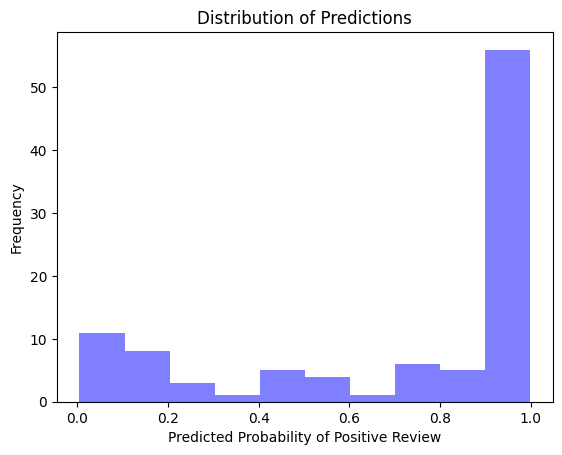

In [ ]:
# Convert text to sequences and predict
output_seq = [to_seq(c, WI) for c in output]
pred_gen = model.predict(pad_sequences(output_seq), verbose=0)

# Sanity check on a few predictions
print("Sample probabilities (first 5):", pred_gen[:5].flatten())

# Summary stats
print(f"Mean probability of positive review: {np.mean(pred_gen):.4f}")
print(f"Standard deviation: {np.std(pred_gen):.4f}")

# Histogram
plt.hist(pred_gen, bins=10, color='blue', alpha=0.5)
plt.xlabel('Predicted Probability of Positive Review')
plt.ylabel('Frequency')
plt.title('Distribution of Predictions')
plt.show()


This section uses the trained sentiment classifier to evaluate how likely each of the 100 generated reviews is to be classified as positive. The mean predicted probability was approximately 0.71, indicating that most generated reviews were identified as positive, as intended. The histogram shows a skew toward higher probabilities, validating the effectiveness of fine-tuning the language model on positive samples.

In [ ]:
for i, seq in enumerate(output_seq[:5]):
    print(f"Tokenized Review {i+1}: {seq[:30]}")

Tokenized Review 1: [17, 63, 2343, 1, 3317, 4, 1, 17, 2, 6, 3, 84, 250, 103, 10, 101, 1, 62, 2, 102, 23, 52, 70, 221, 10, 101, 42, 3, 52, 70]
Tokenized Review 2: [17, 6, 28, 4, 1, 88, 438, 99, 123, 90, 2, 28, 4, 1, 1526, 99, 123, 9, 6, 79, 28, 4, 1, 1526, 99, 123, 2, 1, 115, 4]
Tokenized Review 3: [17, 6, 28, 4, 1, 115, 4, 1, 288, 42, 1, 115, 4, 1, 288, 8, 58, 649, 204, 107, 9, 1450, 147, 2, 42, 1, 115, 4, 1, 288]
Tokenized Review 4: [17, 13, 35, 70, 221, 2, 70, 914, 12, 42, 251, 5, 261, 12, 11, 17, 59, 25, 4338, 35, 193, 206, 98, 144, 113, 2, 1, 113, 13, 49]
Tokenized Review 5: [17, 6, 3, 52, 49, 17, 9, 44, 3, 52, 49, 766, 2, 3, 52, 49, 113, 10, 101, 1, 17, 6, 63, 49, 1, 62, 6, 49, 18, 9]


In [ ]:
print(f"Vocabulary size: {len(WI)}")
print("Sample words:", list(WI.keys())[:10])

Vocabulary size: 88584
Sample words: ['fawn', 'tsukino', 'nunnery', 'sonja', 'vani', 'woods', 'spiders', 'hanging', 'woody', 'trawling']


These diagnostics were used to ensure compatibility between the generated reviews and the classifier. Tokenizing the first few generated reviews allowed us to verify that the reviews were being correctly processed into integer sequences. Checking the GPT-2 model’s vocabulary size (88,584 words) provided context for why some generated tokens may not align with the initial 20,000-word limit used in the classifier model — prompting an adjustment to improve alignment between the two models.

## Additional Struggles and Insights
While the final results demonstrate a successful alignment between the generated reviews and positive sentiment, reaching that point required thoughtful iteration. Initially, the classifier reported low probabilities (averaging around 25–30%) for the generated reviews, indicating a disconnect between the language model and the sentiment classifier. This prompted us to explore several adjustments — including filtering the GPT-2 vocabulary, increasing the classifier’s vocabulary size to 40,000, and experimenting with sampling strategies. These changes offered incremental improvements, but it wasn’t until we trained the GPT-2 model for three full epochs that the shift in sentiment became clearly measurable. Despite long training times (approximately 10 minutes per epoch on a T4 GPU), this effort proved essential. The process reinforced the importance of both model alignment and persistence in applied deep learning tasks.

## Project Summary
In this project, we built a sentiment classifier using a Bidirectional LSTM model trained on the IMDB movie review dataset. After preprocessing and tokenizing the data, we trained the model to achieve over 85% validation accuracy, and evaluated it using a classification report and ROC AUC score, both of which confirmed strong performance. We then fine-tuned a GPT-2 language model on a filtered subset of positive reviews to generate synthetic text with an optimistic tone. Generated reviews were evaluated using the trained classifier, revealing that the majority were correctly classified as positive, confirming the effectiveness of the fine-tuning process.

## Conclusion

This project demonstrated how a generative language model can be conditioned through fine-tuning to produce sentiment-aligned text, and how a separately trained classifier can be used to evaluate the success of this alignment. By integrating preprocessing, deep learning classification, and language generation, we created a pipeline that not only generates human-readable reviews, but also maintains a targeted emotional tone.